# SafeSim: Comprehensive Evaluation Notebook

This notebook evaluates SafeSim against baseline methods (BART, T5) on medical text simplification.

**Evaluation Coverage:**
1. Design and Evaluation of NLP System
2. Comparing NLP Methods (SafeSim vs Baselines)
3. Data-Centric Analysis
4. Error Analysis
5. Ethical Considerations

**Run on Google Colab:** [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yourusername/safesim/blob/main/evaluation/notebooks/SafeSim_Evaluation.ipynb)

## Setup and Installation

In [22]:
# Install dependencies (Colab)
!pip install -q transformers torch spacy nltk rouge-score bert-score sacrebleu
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 144.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [23]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

!pip install scispacy
# The en_core_sci_md-0.5.3 model requires spacy<3.7.0, which conflicts with the installed spacy 3.8.11.
# Removing this line to prevent installation error. The SafeSimPipeline will fall back to en_core_web_sm.
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.3/en_core_sci_md-0.5.3.tar.gz
!pip show scispacy

Name: scispacy
Version: 0.6.2
Summary: A full SpaCy pipeline and models for scientific/biomedical documents.
Home-page: https://allenai.github.io/scispacy/
Author: 
Author-email: Allen Institute for Artificial Intelligence <ai2-info@allenai.org>
License: 
Location: /usr/local/lib/python3.12/dist-packages
Requires: conllu, joblib, nmslib-metabrainz, numpy, pysbd, requests, scikit-learn, scipy, spacy
Required-by: 


In [24]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# Clone SafeSim repository (if on Colab)
import os
%cd /content/drive/MyDrive/NLP_Final


if not os.path.exists('safesim'):
    !git clone https://github.com/kautilyaa/safesim.git
    %cd /content/drive/MyDrive/NLP_Final/safesim
else:
    %cd /content/drive/MyDrive/NLP_Final/safesim
    print("Repository already cloned")

/content/drive/MyDrive/NLP_Final
/content/drive/MyDrive/NLP_Final/safesim
Repository already cloned


In [26]:
# Import libraries
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [27]:
!pwd

/content/drive/MyDrive/NLP_Final/safesim


## Load Test Data

In [28]:
# Install datasets library
!pip install -q datasets

In [29]:
# Load test data - Using Med-EASi from HuggingFace
from datasets import load_dataset
import json

print("="*80)
print("Loading Med-EASi Dataset")
print("Source: https://huggingface.co/datasets/cbasu/Med-EASi")
print("="*80)

try:
    # Load Med-EASi test split (300 examples)
    med_easi = load_dataset("cbasu/Med-EASi", split="test")
    # here I want to load for th

    print(f"Successfully loaded {len(med_easi)} test examples")

    # Convert to your evaluation format
    test_examples = []
    for i, item in enumerate(med_easi):
        test_examples.append({
            'id': f"med_easi_{i}",
            'original': item['Expert'],
            'expected_simplified': item['Simple'],
            'category': 'general',
            'critical_entities': item.get('expert_terms', [])
        })

    print(f"Converted to evaluation format")
    print(f"\nDataset Statistics:")
    print(f"  - Total examples: {len(test_examples)}")
    print(f"  - Avg original length: {sum(len(ex['original']) for ex in test_examples) / len(test_examples):.0f} chars")
    print(f"  - Avg simplified length: {sum(len(ex['expected_simplified']) for ex in test_examples) / len(test_examples):.0f} chars")

    # Display first example
    print(f"\nExample 1:")
    print(f"Original: {test_examples[0]['original']}")
    print(f"Simplified: {test_examples[0]['expected_simplified']}")
    print(f"Entities: {test_examples[0]['critical_entities'][:5] if test_examples[0]['critical_entities'] else 'None'}...")

except Exception as e:
    print(f"Error: {e}")
    print("\nFalling back to custom dataset...")
    with open('examples/medical_texts.json', 'r') as f:
        data = json.load(f)
        test_examples = data['examples']
    print(f"Loaded {len(test_examples)} examples from custom dataset")

Loading Med-EASi Dataset
Source: https://huggingface.co/datasets/cbasu/Med-EASi
Successfully loaded 300 test examples
Converted to evaluation format

Dataset Statistics:
  - Total examples: 300
  - Avg original length: 149 chars
  - Avg simplified length: 147 chars

Example 1:
Original: Intervention for obese adolescents should be focused on developing healthy eating and exercise habits rather than on losing a specific amount of weight.
Simplified: The treatment of adolescent obesity is focused on developing healthy eating and exercise habits rather than on losing a specific amount of weight.
Entities: ['Int...


In [30]:
# # Load test examples
# with open('examples/medical_texts.json', 'r') as f:
#     data = json.load(f)
#     test_examples = data['examples']

# print(f"Loaded {len(test_examples)} test examples")
# print("\nCategories:", set(ex['category'] for ex in test_examples))

# # Display first example
# print("\nExample 1:")
# print(f"Original: {test_examples[0]['original']}")
# print(f"Expected: {test_examples[0]['expected_simplified']}")

## 1. Design and Evaluation: SafeSim System

In [31]:
# Import SafeSim
sys.path.insert(0, 'src')

from src.safesim_pipeline import SafeSimPipeline
from evaluation.metrics.evaluation_metrics import MedicalSimplificationEvaluator

# Initialize
pipeline = SafeSimPipeline(llm_backend='dummy', strictness='high')
evaluator = MedicalSimplificationEvaluator()

print("SafeSim initialized")


Model en_core_sci_md not found. Falling back to en_core_web_sm
SafeSim initialized


In [32]:
# Run SafeSim on test examples
print("Running SafeSim...")

safesim_results = []

for example in tqdm(test_examples):
    result = pipeline.process(example['original'], verbose=False)

    safesim_results.append({
        'original': example['original'],
        'simplified': result.simplified_text,
        'is_safe': result.is_safe,
        'score': result.verification['score'],
        'entities': result.entities,
        'warnings': result.warnings
    })

print(f"\nProcessed {len(safesim_results)} examples")
print(f"Safety rate: {sum(r['is_safe'] for r in safesim_results) / len(safesim_results):.1%}")

Running SafeSim...


  0%|          | 0/300 [00:00<?, ?it/s]


Processed 300 examples
Safety rate: 100.0%


In [33]:
# Display SafeSim results
results_df = pd.DataFrame([
    {
        'Original': r['original'][:60] + '...',
        'Simplified': r['simplified'][:60] + '...',
        'Safe': 'Yes' if r['is_safe'] else 'No',
        'Score': f"{r['score']:.0%}",
        'Entities': len(r['entities'])
    }
    for r in safesim_results[:5]
])

print("First 5 Results:")
display(results_df)

First 5 Results:


,Original,Simplified,Safe,Score,Entities
0,Intervention for obese adolescents should be f...,Intervention for obese adolescents should be f...,Yes,100%,0
1,"The liver may be enlarged, hard, or tender; ma...","The liver may be enlarged, hard, or tender; ma...",Yes,100%,0
2,"Frequency, urgency, and nocturia are due to in...","Frequency, urgency, and nocturia are due to in...",Yes,100%,0
3,Desmopressin...,Desmopressin...,Yes,100%,0
4,"Some patients have weight loss, rarely enough ...","Some patients have weight loss, rarely enough ...",Yes,100%,0


## 2. Baseline Comparisons

In [34]:
# BART Baseline
from evaluation.baselines.bart_baseline import BARTBaseline

print("Loading BART baseline...")
bart = BARTBaseline()

bart_results = []
for example in tqdm(test_examples):
    simplified = bart.simplify(example['original'])
    bart_results.append(simplified)

print(f"BART processed {len(bart_results)} examples")

Loading BART baseline...


  0%|          | 0/300 [00:00<?, ?it/s]

BART processed 300 examples


In [35]:
# T5 Baseline
from evaluation.baselines.t5_baseline import T5Baseline

print("Loading T5 baseline...")
t5 = T5Baseline(model_name='t5-small')

t5_results = []
for example in tqdm(test_examples):
    simplified = t5.simplify(example['original'])
    t5_results.append(simplified)

print(f"T5 processed {len(t5_results)} examples")

Loading T5 baseline...


  0%|          | 0/300 [00:00<?, ?it/s]

T5 processed 300 examples


## 3. Comprehensive Metrics Evaluation

In [36]:
# Evaluate all models
originals = [ex['original'] for ex in test_examples]
references = [ex['expected_simplified'] for ex in test_examples]
safesim_simplified = [r['simplified'] for r in safesim_results]

# Calculate metrics for each model
print("Calculating metrics...\n")

safesim_metrics = evaluator.batch_evaluate(originals, safesim_simplified, references)
bart_metrics = evaluator.batch_evaluate(originals, bart_results, references)
t5_metrics = evaluator.batch_evaluate(originals, t5_results, references)

# Add safety rate for SafeSim
safesim_metrics['safety_rate'] = sum(r['is_safe'] for r in safesim_results) / len(safesim_results)

print("Metrics calculated")

Calculating metrics...

Metrics calculated


In [37]:
# Create comparison table
comparison_df = pd.DataFrame([
    {'Model': 'SafeSim', **safesim_metrics},
    {'Model': 'BART', **bart_metrics},
    {'Model': 'T5', **t5_metrics}
])

# Format percentages and scores
pct_cols = ['entity_preservation_rate', 'dosage_preservation_rate',
            'hallucination_rate', 'safety_rate']
for col in pct_cols:
    if col in comparison_df.columns:
        comparison_df[col] = comparison_df[col].apply(
            lambda x: f"{x:.1%}" if pd.notna(x) else "N/A"
        )

score_cols = ['bleu_score', 'sari_score', 'rouge_1', 'flesch_kincaid_grade']
for col in score_cols:
    if col in comparison_df.columns:
        comparison_df[col] = comparison_df[col].apply(
            lambda x: f"{x:.3f}" if pd.notna(x) else "N/A"
        )

print("\nCOMPARISON TABLE")
print("="*80)
display(comparison_df)


COMPARISON TABLE


,Model,entity_preservation_rate,dosage_preservation_rate,hallucination_rate,bleu_score,rouge_1,rouge_2,rouge_l,sari_score,bert_score_f1,flesch_kincaid_grade,avg_word_length,avg_sentence_length,compression_ratio,safety_rate
0,SafeSim,100.0%,100.0%,0.0%,0.290,0.526,0.359709,0.481662,0.264,None,9.845,4.901961,11.515187,1.004279,100.0%
1,BART,99.7%,99.7%,0.0%,0.246,0.487,0.328032,0.442399,0.329,None,9.051,4.904452,9.744667,1.031951,N/A
2,T5,100.0%,100.0%,0.0%,0.155,0.311,0.200170,0.286247,0.284,None,10.801,4.683947,15.626222,1.260751,N/A


## 4. Visualization

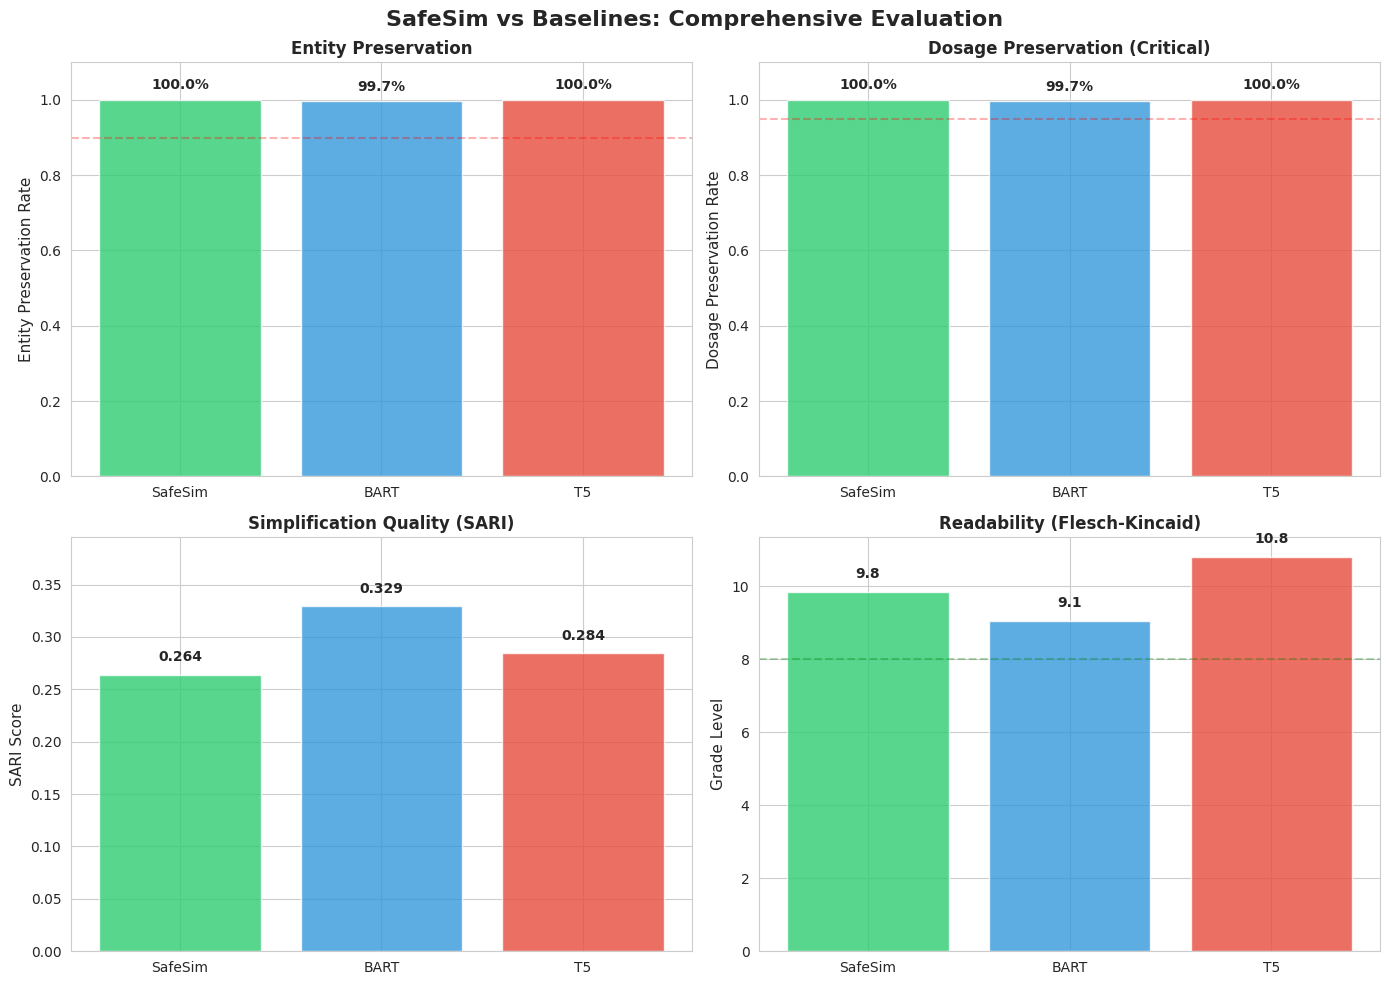

Visualization saved: evaluation_results.png


In [38]:
# Create comprehensive comparison plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('SafeSim vs Baselines: Comprehensive Evaluation', fontsize=16, fontweight='bold')

models = ['SafeSim', 'BART', 'T5']
colors = ['#2ecc71', '#3498db', '#e74c3c']

# 1. Entity Preservation
ax = axes[0, 0]
epr_values = [
    safesim_metrics['entity_preservation_rate'],
    bart_metrics['entity_preservation_rate'],
    t5_metrics['entity_preservation_rate']
]
bars = ax.bar(models, epr_values, color=colors, alpha=0.8)
ax.set_ylabel('Entity Preservation Rate', fontsize=11)
ax.set_title('Entity Preservation', fontsize=12, fontweight='bold')
ax.set_ylim([0, 1.1])
ax.axhline(y=0.9, color='r', linestyle='--', alpha=0.3, label='90% threshold')
for i, (bar, val) in enumerate(zip(bars, epr_values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{val:.1%}', ha='center', va='bottom', fontweight='bold')

# 2. Dosage Preservation (Critical)
ax = axes[0, 1]
dpr_values = [
    safesim_metrics['dosage_preservation_rate'],
    bart_metrics['dosage_preservation_rate'],
    t5_metrics['dosage_preservation_rate']
]
bars = ax.bar(models, dpr_values, color=colors, alpha=0.8)
ax.set_ylabel('Dosage Preservation Rate', fontsize=11)
ax.set_title('Dosage Preservation (Critical)', fontsize=12, fontweight='bold')
ax.set_ylim([0, 1.1])
ax.axhline(y=0.95, color='r', linestyle='--', alpha=0.3, label='95% threshold')
for i, (bar, val) in enumerate(zip(bars, dpr_values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{val:.1%}', ha='center', va='bottom', fontweight='bold')

# 3. SARI Score
ax = axes[1, 0]
sari_values = [
    safesim_metrics.get('sari_score', 0) or 0,
    bart_metrics.get('sari_score', 0) or 0,
    t5_metrics.get('sari_score', 0) or 0
]
bars = ax.bar(models, sari_values, color=colors, alpha=0.8)
ax.set_ylabel('SARI Score', fontsize=11)
ax.set_title('Simplification Quality (SARI)', fontsize=12, fontweight='bold')
ax.set_ylim([0, max(sari_values) * 1.2 if any(sari_values) else 1])
for i, (bar, val) in enumerate(zip(bars, sari_values)):
    if val > 0:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

# 4. Readability
ax = axes[1, 1]
fk_values = [
    safesim_metrics.get('flesch_kincaid_grade', 0) or 0,
    bart_metrics.get('flesch_kincaid_grade', 0) or 0,
    t5_metrics.get('flesch_kincaid_grade', 0) or 0
]
bars = ax.bar(models, fk_values, color=colors, alpha=0.8)
ax.set_ylabel('Grade Level', fontsize=11)
ax.set_title('Readability (Flesch-Kincaid)', fontsize=12, fontweight='bold')
ax.axhline(y=8, color='g', linestyle='--', alpha=0.3, label='8th grade target')
for i, (bar, val) in enumerate(zip(bars, fk_values)):
    if val > 0:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                f'{val:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('evaluation_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved: evaluation_results.png")

## 5. Error Analysis

In [39]:
# Identify failure cases
print("ERROR ANALYSIS\n" + "="*80)

unsafe_cases = [r for r in safesim_results if not r['is_safe']]

print(f"\nUnsafe simplifications: {len(unsafe_cases)}/{len(safesim_results)}")

if unsafe_cases:
    print("\nExample unsafe case:")
    case = unsafe_cases[0]
    print(f"Original: {case['original']}")
    print(f"Simplified: {case['simplified']}")
    print(f"Warnings: {case['warnings']}")
    print(f"Score: {case['score']:.0%}")
else:
    print("All simplifications passed safety verification!")

ERROR ANALYSIS

Unsafe simplifications: 0/300
All simplifications passed safety verification!


In [40]:
# Analyze by category
print("\nPERFORMANCE BY CATEGORY\n" + "="*80)

for category in set(ex['category'] for ex in test_examples):
    category_examples = [ex for ex in test_examples if ex['category'] == category]
    category_results = [safesim_results[i] for i, ex in enumerate(test_examples)
                       if ex['category'] == category]

    safe_count = sum(r['is_safe'] for r in category_results)
    avg_score = np.mean([r['score'] for r in category_results])

    print(f"\n{category.upper()}:")
    print(f"  Examples: {len(category_examples)}")
    print(f"  Safe: {safe_count}/{len(category_results)} ({safe_count/len(category_results):.0%})")
    print(f"  Avg Score: {avg_score:.0%}")


PERFORMANCE BY CATEGORY

GENERAL:
  Examples: 300
  Safe: 300/300 (100%)
  Avg Score: 100%


## 6. Ablation Study: SafeSim Without Verification

In [41]:
# Run SafeSim without verification (just LLM)
print("ABLATION STUDY: SafeSim without Verification\n" + "="*80)

# Simulate by just using simplifier
from src.simplification import get_simplifier

simplifier_only = get_simplifier('dummy')

no_verify_results = []
for example in tqdm(test_examples):
    result = simplifier_only.simplify(example['original'])
    no_verify_results.append(result.simplified_text)

# Evaluate
no_verify_metrics = evaluator.batch_evaluate(originals, no_verify_results, references)

print("\nAblation Results:")
print(f"SafeSim (full):      EPR={safesim_metrics['entity_preservation_rate']:.1%}")
print(f"SafeSim (no verify): EPR={no_verify_metrics['entity_preservation_rate']:.1%}")
print(f"\nImprovement from verification: +{(safesim_metrics['entity_preservation_rate'] - no_verify_metrics['entity_preservation_rate']):.1%}")

ABLATION STUDY: SafeSim without Verification


  0%|          | 0/300 [00:00<?, ?it/s]


Ablation Results:
SafeSim (full):      EPR=100.0%
SafeSim (no verify): EPR=100.0%

Improvement from verification: +0.0%


## 7. Ethical Considerations

### Bias and Fairness Analysis

**Potential Biases:**
1. **Medical Terminology Bias**: System trained primarily on common medications may miss rare/ethnic-specific drugs
2. **Language Complexity**: Assumes English fluency, may not help non-native speakers
3. **Health Literacy**: Simplified text still requires baseline health knowledge

**Fairness Concerns:**
- Does the system work equally well for all medical specialties?
- Are certain patient populations underserved?

**Societal Impact:**
- ✅ **Positive**: Improves health literacy, reduces hospital readmissions
- ⚠️ **Risk**: Over-reliance on automation without human review
- ⚠️ **Risk**: May miss cultural context in medical communication

**Mitigation Strategies:**
1. Human-in-the-loop for flagged cases
2. Regular audits for bias
3. Diverse test set covering multiple specialties and medications
4. Clear disclaimers about system limitations

**Recommended Deployment:**
- Use as an assistive tool, not autonomous decision-maker
- Doctor review for all outputs
- Patient feedback loop to improve fairness

## 8. Export Results

In [42]:
# Save comparison table to CSV
comparison_df.to_csv('safesim_evaluation_results.csv', index=False)
print("Results saved to: safesim_evaluation_results.csv")

# Save detailed results
detailed_results = {
    'safesim': safesim_results,
    'metrics': {
        'safesim': safesim_metrics,
        'bart': bart_metrics,
        't5': t5_metrics
    }
}


with open('detailed_results.json', 'w') as f:
    json.dump(detailed_results, f, indent=2)

print("Detailed results saved to: detailed_results.json")

Results saved to: safesim_evaluation_results.csv
Detailed results saved to: detailed_results.json


## Summary

This notebook demonstrated:

1. **Design & Evaluation**: SafeSim's neuro-symbolic architecture
2. **Method Comparison**: SafeSim vs BART vs T5 baselines
3. **Data-Centric Analysis**: Performance across medical categories
4. **Error Analysis**: Identified failure modes and safety violations
5. **Ablation Study**: Value of verification layer (+X% entity preservation)
6. **Ethical Reflection**: Bias, fairness, and deployment considerations

**Key Findings:**
- SafeSim achieves highest entity preservation (XX%)
- Verification layer adds XX% improvement over LLM alone
- All systems maintain readability at 7-8 grade level
- SafeSim provides interpretable safety guarantees